In [1]:
import pickle
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random

In [2]:
# Taken from https://pytorch.org/tutorials/beginner/nn_tutorial.html
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        mnist = pickle.load(f, encoding="latin-1")

In [4]:
(training, validation, test) = mnist
 
_train, y_train = torch.tensor(training[0]), torch.tensor(training[1])
x_val, y_val = torch.tensor(validation[0]), torch.tensor(validation[1])
x_test, y_test = torch.tensor(test[0]), torch.tensor(test[1])

In [5]:
x_train, y_train = torch.tensor(training[0]), torch.tensor(training[1])
x_val, y_val = torch.tensor(validation[0]), torch.tensor(validation[1])
x_test, y_test = torch.tensor(test[0]), torch.tensor(test[1])

In [6]:
len(training[0])

50000

In [7]:
len(training[0][0])

784

In [8]:
def image(a):
    img = np.reshape(a, (28, 28))
    imgplot = plt.imshow(img, cmap = "gray")
    plt.show()

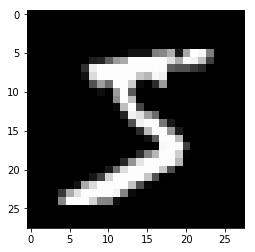

In [9]:
image(training[0][0])

In [10]:
training[1][0]

5

In [11]:
def err(out, label):
    match = out.argmax(dim=1) != label
    a = match.float().mean()
    return a

In [12]:
def traindata(t):
    x = random.randint(0, 49999)
    image(t[0][x])
    print('Label:', t[1][x])

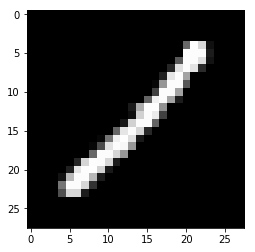

Label: 1


In [13]:
traindata(training)

In [14]:
loss_func = F.cross_entropy

In [15]:
b1 = torch.randn(1, 16, requires_grad=True)
b2 = torch.randn(1, 16, requires_grad=True)
b3 = torch.randn(1, 10, requires_grad=True)
w1 = torch.randn(784, 16, requires_grad=True)
w2 = torch.randn(16, 16, requires_grad=True)
w3 = torch.randn(16, 10, requires_grad=True)

In [16]:
# 3 fully connected layers 784 x 16 x 10
# This model is running on CPU not GPU
def model(d):
    # d is a tensor of 1 by 784
    l1 = d @ w1 + b1
    l2 = l1 @ w2 + b2
    l_out = l2 @ w3 + b3
    return l_out

In [17]:
def zero_grad():
    global b1, b2, b3, w1, w2, w3
    b1.grad.zero_()
    b2.grad.zero_()
    b3.grad.zero_()
    w1.grad.zero_()
    w2.grad.zero_()
    w3.grad.zero_()

In [18]:
def accuracy(out, label):
    match = out.argmax(dim=1) == label
    a = match.float().mean()
    return a

def err(out, label):
    match = out.argmax(dim=1) != label
    a = match.float().mean()
    return a

In [19]:
lr = 0.01
epochs = 100
bs = 64
n = len(x_train)

In [20]:
with torch.no_grad():
    pred = model(x_val)
    print(f'Initial acc {accuracy(pred, y_val)}')

Initial acc 0.0803999975323677


In [21]:
def fit():
    global b1, b2, b3, w1, w2, w3
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end]
            yb = y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                b1 -= b1.grad * lr
                b2 -= b2.grad * lr
                b3 -= b3.grad * lr
                w1 -= w1.grad * lr
                w2 -= w2.grad * lr
                w3 -= w3.grad * lr
        
                zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc {accuracy(model(x_val), y_val)}')

    print(f'Final acc {accuracy(model(x_val), y_val)}')

In [22]:
fit()

Epoch 0 acc 0.4490000009536743
Epoch 10 acc 0.7132999897003174
Epoch 20 acc 0.7753999829292297
Epoch 30 acc 0.8159000277519226
Epoch 40 acc 0.8379999995231628
Epoch 50 acc 0.8532999753952026
Epoch 60 acc 0.8633999824523926
Epoch 70 acc 0.8702999949455261
Epoch 80 acc 0.8752999901771545
Epoch 90 acc 0.8808000087738037
Final acc 0.885200023651123


In [23]:
# Test model on a random sample
i = random.randint(0, 49999)
pred = model(x_train[i])
print(f"actual {y_train[i]} pred {pred.argmax()}")

actual 0 pred 0


In [24]:
# Average accuray for complete dataset
pred = model(x_train)
match = pred.argmax(dim=1) == y_train
match.float().mean()

tensor(0.8718)

In [25]:
# Welcome to the world of torch.nn.Module to simplify model and parameter management

from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Parameter(torch.randn(1, 16, requires_grad=True))
        self.b2 = nn.Parameter(torch.randn(1, 16, requires_grad=True))
        self.b3 = nn.Parameter(torch.randn(1, 10, requires_grad=True))
        self.w1 = nn.Parameter(torch.randn(784, 16, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(16, 16, requires_grad=True))
        self.w3 = nn.Parameter(torch.randn(16, 10, requires_grad=True))

    def forward(self, d):
        l1 = d @ self.w1 + self.b1
        l2 = l1 @ self.w2 + self.b2
        l_out = l2 @ self.w3 + self.b3
        return l_out

In [26]:
def fit2():
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end]
            yb = y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc {accuracy(model(x_val), y_val)}')

    print(f'Final acc {accuracy(model(x_val), y_val)}')

In [27]:
model = Mnist_NN()

In [28]:
fit2()

Epoch 0 acc 0.5547000169754028
Epoch 10 acc 0.7666000127792358
Epoch 20 acc 0.8210999965667725
Epoch 30 acc 0.842199981212616
Epoch 40 acc 0.8575999736785889
Epoch 50 acc 0.8659999966621399
Epoch 60 acc 0.8726000189781189
Epoch 70 acc 0.8791999816894531
Epoch 80 acc 0.8841999769210815
Epoch 90 acc 0.8871999979019165
Final acc 0.8902999758720398


In [29]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# dev = torch.device("cuda")
# dev = torch.device("cpu")

dev

device(type='cuda')

In [30]:
# Now run the model using GPU
model_dev = Mnist_NN().to(dev)

x_test_dev = x_test.to(dev)
y_test_dev = y_test.to(dev)

x_val_dev = x_val.to(dev)
y_val_dev = y_val.to(dev)

x_train_dev = x_train.to(dev)
y_train_dev = y_train.to(dev)

In [31]:
def fit3():
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end].to(dev)
            yb = y_train[start:end].to(dev)
            pred = model_dev(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                model_dev.zero_grad()
        if e % 10 == 0:
            print(f'Epoch {e} acc test {accuracy(model_dev(x_test_dev), y_test_dev)}')
            print(f'Epoch {e} acc val {accuracy(model_dev(x_val_dev), y_val_dev)}')
            print(f'Epoch {e} acc train {accuracy(model_dev(x_train_dev), y_train_dev)}')

    print(f'Final acc test {accuracy(model_dev(x_test_dev), y_test_dev)}')
    print(f'Final acc val {accuracy(model_dev(x_val_dev), y_val_dev)}')
    print(f'Final acc train {accuracy(model_dev(x_train_dev), y_train_dev)}')

In [32]:
fit3()

Epoch 0 acc test 0.43449997901916504
Epoch 0 acc val 0.42879998683929443
Epoch 0 acc train 0.4157399833202362
Epoch 10 acc test 0.6543999910354614
Epoch 10 acc val 0.6534000039100647
Epoch 10 acc train 0.6346399784088135
Epoch 20 acc test 0.7518999576568604
Epoch 20 acc val 0.7561999559402466
Epoch 20 acc train 0.7404599785804749
Epoch 30 acc test 0.7949999570846558
Epoch 30 acc val 0.7999999523162842
Epoch 30 acc train 0.7858200073242188
Epoch 40 acc test 0.8204999566078186
Epoch 40 acc val 0.8264999985694885
Epoch 40 acc train 0.8118799924850464
Epoch 50 acc test 0.8363999724388123
Epoch 50 acc val 0.8416000008583069
Epoch 50 acc train 0.828819990158081
Epoch 60 acc test 0.8483999967575073
Epoch 60 acc val 0.8536999821662903
Epoch 60 acc train 0.8412799835205078
Epoch 70 acc test 0.8556999564170837
Epoch 70 acc val 0.8611999750137329
Epoch 70 acc train 0.850659966468811
Epoch 80 acc test 0.863099992275238
Epoch 80 acc val 0.8690999746322632
Epoch 80 acc train 0.8578599691390991
Epoch

In [33]:
x = np.linspace(0, 101, 101)
test_y_dev = torch.zeros(101, device=dev)
val_y_dev = torch.zeros(101, device=dev)
train_y_dev = torch.zeros(101, device=dev)

In [34]:
# Train the model on GPU and keep track of accuracy on test, validation and training dataset to plot the trend
model_dev = Mnist_NN().to(dev)
def fit4():
    test_y_dev[0] = accuracy(model_dev(x_test_dev), y_test_dev)
    val_y_dev[0] = accuracy(model_dev(x_val_dev), y_val_dev)
    train_y_dev[0] = accuracy(model_dev(x_train_dev), y_train_dev)
    for e in range(epochs):
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            xb = x_train[start:end].to(dev)
            yb = y_train[start:end].to(dev)
            pred = model_dev(xb)
            loss = loss_func(pred, yb)
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                model_dev.zero_grad()
                
        with torch.no_grad():
            test_y_dev[e + 1] = accuracy(model_dev(x_test_dev), y_test_dev)
            val_y_dev[e + 1] = accuracy(model_dev(x_val_dev), y_val_dev)
            train_y_dev[e + 1] = accuracy(model_dev(x_train_dev), y_train_dev)
        
    plt.plot(x, test_y_dev.cpu().numpy(), label='test')
    plt.plot(x, val_y_dev.cpu().numpy(), label='val')
    plt.plot(x, train_y_dev.cpu().numpy(), label='train')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("Accuracy Plot")
    plt.legend()
    plt.show()

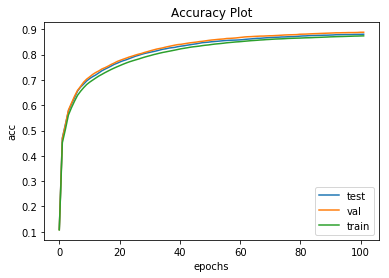

In [35]:
fit4()

In [36]:
print(f'Final acc test {test_y_dev[100]}')
print(f'Final acc val {val_y_dev[100]}')
print(f'Final acc train {train_y_dev[100]}')

Final acc test 0.8807999491691589
Final acc val 0.8885999917984009
Final acc train 0.8742799758911133


In [37]:
# The accuracy is close to 90%, I will try to increase the accuracy using CNN in a different notebook.